### Climate skill at 1&deg;: annual- and global-mean time series

In [1]:
from collections import namedtuple
import warnings

import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl

from utils import get_beaker_dataset_variables
from constants import INFERENCE_COMPARISON_1DEG

In [2]:
# beaker downloads trigger this noisy warning
warnings.filterwarnings("ignore", message='install "ipywidgets" for Jupyter support')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rc('font', size=8)

In [3]:
EvalVar = namedtuple("EvalVar", ("name", "long_name", "units"))

EVAL_VARS = [
    EvalVar("TMP2m", "2-meter air temperature", "K"),
    EvalVar("total_water_path", "total water path", "mm"),
]
ADDITIONAL_VARS = ['surface_temperature']
DS_VARS = [var.name for var in EVAL_VARS] + ADDITIONAL_VARS

In [4]:
datasets = []
for duration_name, duration_runs in INFERENCE_COMPARISON_1DEG.items():
    for group_name, group_runs in duration_runs.items():
        if isinstance(group_runs, dict):
            for ic_name, ic_run in group_runs.items():
                full_key = '/'.join([duration_name, group_name, ic_name])
                print(f"Getting run: {full_key=}")
                ic_dataset = get_beaker_dataset_variables(ic_run, 'annual_diagnostics.nc', DS_VARS)
                datasets.append(
                    ic_dataset
                    .expand_dims({'duration': [duration_name], 'group': [group_name], 'IC': [ic_name]})
                )
        else:
            full_key = '/'.join([duration_name, group_name])
            print(f"Getting run: {full_key=}")
            source_dataset = get_beaker_dataset_variables(group_runs, 'annual_diagnostics.nc', DS_VARS)
            datasets.append(
                source_dataset
                .expand_dims({'duration': [duration_name], 'group': [group_name]})
            )
annual_mean_ds = xr.merge(datasets).squeeze()

Getting run: full_key='10yr/ERA5-ACEv2'


Getting run: full_key='10yr/SHiELD-AMIP-ACEv2/IC0'


Getting run: full_key='10yr/SHiELD-AMIP-ACEv2/IC1'


Getting run: full_key='10yr/SHiELD-AMIP-ACEv2/IC2'


Getting run: full_key='10yr/SHiELD-AMIP-reference'


Getting run: full_key='10yr/SHiELD-AMIP-vs.-ERA5/IC0'


Getting run: full_key='10yr/SHiELD-AMIP-vs.-ERA5/IC1'


Getting run: full_key='82yr/ERA5-ACEv2'


Getting run: full_key='82yr/SHiELD-AMIP-ACEv2/IC0'


Getting run: full_key='82yr/SHiELD-AMIP-ACEv2/IC1'


Getting run: full_key='82yr/SHiELD-AMIP-ACEv2/IC2'


Getting run: full_key='82yr/SHiELD-AMIP-reference'


Getting run: full_key='82yr/SHiELD-AMIP-vs.-ERA5/IC0'


Getting run: full_key='82yr/SHiELD-AMIP-vs.-ERA5/IC1'


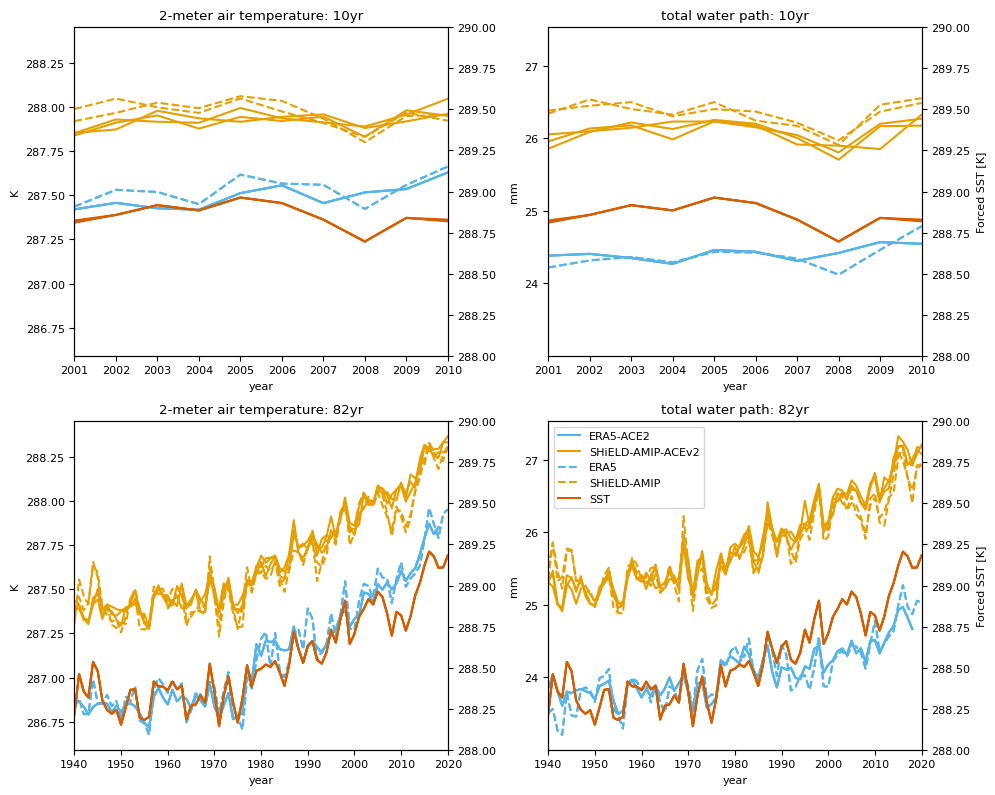

In [5]:
fig, axes = plt.subplots(annual_mean_ds.sizes['duration'], len(EVAL_VARS), sharex='row', sharey='col')
for ax_row, duration in zip(axes, annual_mean_ds.duration):
    for ax, var in zip(ax_row, EVAL_VARS):
        hae = annual_mean_ds.sel(source='prediction', duration=duration, group='ERA5-ACEv2')[var.name].plot(
            ax=ax, hue='IC', color=colors[0], add_legend=False
        )
        has = annual_mean_ds.sel(source='prediction', duration=duration, group='SHiELD-AMIP-ACEv2')[var.name].plot(
            ax=ax, hue='IC', color=colors[1], label='SHiELD-AMIP-ACEv2', add_legend=False
        )
        he = annual_mean_ds.sel(source='target', duration=duration, group='SHiELD-AMIP-vs.-ERA5')[var.name].plot(
            ax=ax, hue='IC', color=colors[0], ls='--', label='ERA5', add_legend=False
        )
        ha = annual_mean_ds.sel(source='prediction', duration=duration, group='SHiELD-AMIP-vs.-ERA5')[var.name].plot(
            ax=ax, hue='IC', color=colors[1], ls='--', label='SHiELD-AMIP', add_legend=False
        )
        ax2 = ax.twinx()
        hs = annual_mean_ds.sel(source='target', duration=duration, group='SHiELD-AMIP-ACEv2').surface_temperature.plot(
            ax=ax2, hue='IC', color=colors[4], label='SST', add_legend=False
        )
        ax2.set_title(None)
        if ax == ax_row[-1]:
            ax2.set_ylabel('Forced SST [K]')
        else:
            ax2.set_ylabel(None)
        ax2.set_ylim([288, 290])
        if duration.item() == '82yr':
            ax.set_xlim([1940, 2020])
        else:
            ax.set_xlim([2001, 2010])
        ax.set_ylabel(var.units)
        ax.set_title(f"{var.long_name}: {duration.item()}")
axes[-1, -1].legend(
    [hae[0], has[0], he[0], ha[0], hs[0]],
    ['ERA5-ACE2', 'SHiELD-AMIP-ACEv2', 'ERA5', 'SHiELD-AMIP', 'SST']
)
fig.set_size_inches([10, 8])
fig.tight_layout()
fig.savefig('annual_mean_series.png', bbox_inches='tight', facecolor='w')